In [223]:
pip install skforecast


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [246]:
# Plots
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Model imports
# ==============================================================================
import sklearn
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_squared_error
from skforecast.model_selection import backtesting_forecaster

# ONNX imports
# ==============================================================================
import os
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [226]:
# Load data
# ==============================================================================
data = pd.read_csv('training_data/historical.csv')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

Train dates : 1992-04-01 00:00:00 --- 2002-06-01 00:00:00  (n=123)
Test dates  : 2002-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=36)


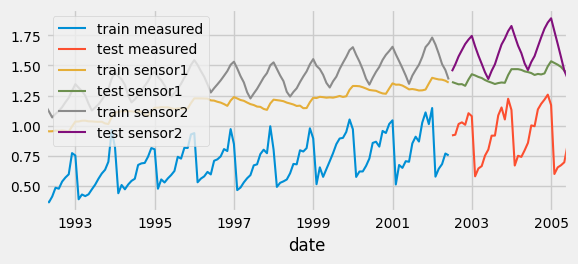

In [230]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train measured')
data_test['y'].plot(ax=ax, label='test measured')
data_train['exog_1'].plot(ax=ax, label='train sensor1')
data_test['exog_1'].plot(ax=ax, label='test sensor1')
data_train['exog_2'].plot(ax=ax, label='train sensor2')
data_test['exog_2'].plot(ax=ax, label='test sensor2')
ax.legend(loc='upper left');

In [231]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.011247439821175929



In [232]:
# Search results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.011247,3,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 100}",0.011266,8,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 250}",0.011328,8,250
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",0.011832,3,250
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.027219,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",0.027297,3,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 100}",0.028937,8,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 250}",0.030026,8,250


In [233]:
forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2002-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-10-23 20:12:58 
Last fit date: 20

In [234]:
# Validation
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

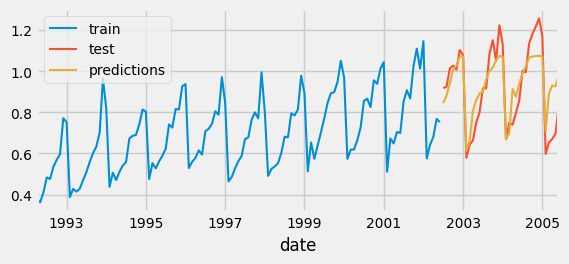

In [235]:
# Plot Validation
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [236]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.012418331184952941


# Train using the whole historical dataset

In [237]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data['y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 8, 'n_estimators': 250}
  Backtesting metric: 0.020704299837193726



In [238]:
forecaster.fit(y=data['y'], exog=data[['exog_1','exog_2']])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=8, n_estimators=250, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-10-23 20:14:44 

In [243]:
# New Predictions
# ==============================================================================
sensors_data = pd.read_csv('training_data/sensors_data.csv')
sensors_data['date'] = pd.to_datetime(sensors_data['date'], format='%Y-%m-%d')
sensors_data = sensors_data.set_index('date')
sensors_data = sensors_data.asfreq('MS')

In [244]:
predictions = forecaster.predict(steps=len(sensors_data), exog=sensors_data[['exog_1', 'exog_2']])

In [245]:
measured_value = pd.read_csv('training_data/measured_value.csv')
measured_value['date'] = pd.to_datetime(measured_value['date'], format='%Y-%m-%d')
measured_value = measured_value.set_index('date')
measured_value = measured_value.asfreq('MS')

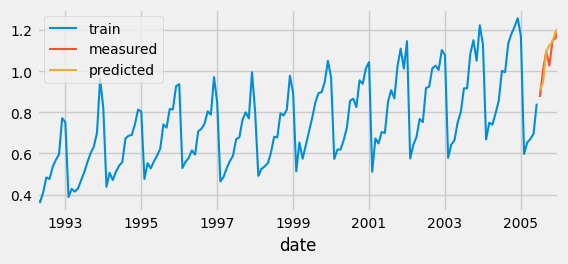

In [242]:
# Plot Prediction
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data['y'].plot(ax=ax, label='train')
measured_value['y'].plot(ax=ax, label='measured')
predictions.plot(ax=ax, label='predicted')
ax.legend();

In [247]:
# Predictive error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = measured_value['y'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.0025687790006539216


In [248]:
# Extract the trained regressor
regressor = forecaster.regressor

# Define the entry type for ONNX using 20 lags
initial_type = [('float_input', FloatTensorType([None, 20]))]

# Convert the model to ONNX
onnx_model = convert_sklearn(regressor, initial_types=initial_type)
os.makedirs("models/edge/1", exist_ok=True)
onnx.save(onnx_model, "models/edge/1/model.onnx")

In [250]:
# Store new historical data
new_historical = pd.concat([measured_value, sensors_data], axis=1)
new_historical = pd.concat([data, new_historical])

os.makedirs("upload_data", exist_ok=True)
new_historical.to_csv('upload_data/historical.csv', sep=',', index=True, header=True)